In [1]:
# Standar libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os
import yaml

# DPIVSoft libraries
import dpivsoft.DPIV as DPIV      #Python PIV implementation
import dpivsoft.Cl_DPIV as Cl_DPIV   #OpenCL PIV implementation
import dpivsoft.SyIm as SyIm  #Syntetic images generator

from dpivsoft.Classes  import Parameters
from dpivsoft.Classes  import grid
from dpivsoft.Classes  import GPU
from dpivsoft.Classes  import Synt_Img

%matplotlib widget

In [2]:
def readParameters(fileName):
        """
        Read parameters from a yaml file
        """
        with open(fileName) as f:
            data = yaml.load(f, Loader=yaml.FullLoader)
            print("starting")

            #try:
            #Default first step parameters
            Parameters.box_size_1_x = data['box_size_1_x']
            Parameters.box_size_1_y = data['box_size_1_y']
            Parameters.no_boxes_1_x = data['no_boxes_1_x']
            Parameters.no_boxes_1_y = data['no_boxes_1_y']
            Parameters.window_1_x =   data['window_1_x']
            Parameters.window_1_y =   data['window_1_y']

            #Number of pass of first step
            Parameters.no_iter_1 = data['no_iter_1']
            Parameters.no_iter_2 = data['no_iter_2']

            #Direct calculation or FFT
            Parameters.direct_calc = data['direct_calc']

            #Default first step parameters
            Parameters.box_size_2_x = data['box_size_2_x']
            Parameters.box_size_2_y = data['box_size_2_y']
            Parameters.no_boxes_2_x = data['no_boxes_2_x']
            Parameters.no_boxes_2_y = data['no_boxes_2_y']
            Parameters.window_2_x =   data['window_2_x']
            Parameters.window_2_y =   data['window_2_y']

            #default general parameters

            try:
                Parameters.mask = data['mask']
            except:
                Parameters.mask = 0
            try:
                Parameters.stereo = data['stereo']
            except:
                Parameters.stereo = 0

            Parameters.peak_ratio = data['peak_ratio']
            Parameters.weighting = data['weighting']
            Parameters.gaussian_size = data['gaussian_size']
            Parameters.median_limit = data['median_limit']
            Parameters.calibration = data['calibration']
            Parameters.delta_t = data['delta_t']

            #Extra data
            if Parameters.mask:
                if data['path_mask'].endswith('.np'):
                    Parameters.Data.mask = bool(np.load(data['path_mask']))
                else:
                    Parameters.Data.mask = np.asarray(cv2.cvtColor(cv2.imread(
                        data['path_mask']), cv2.COLOR_BGR2GRAY)).astype(bool)

            if Parameters.stereo:
                Parameters.stereo_calibration = Parameters.Stereo_Calibration(
                        data['path_stereo'])
        return data        

# If you need to split a movie into frame, you  an use this routine or the standalone python code movieTOframes.py on the GitHub.

In [ ]:
input_file='/Users/jeromenoir/polybox2/ENSEIGNEMENTS/INTRO_FLUID_DYNAMICS/EXAM/Exams_2024/Report1_BUCKET/movie1_r35.MOV'
output_dir='/Users/jeromenoir/polybox2/ENSEIGNEMENTS/INTRO_FLUID_DYNAMICS/EXAM/Exams_2024/Report1_BUCKET/movie1_r35frames'

video = cv2.VideoCapture(input_file)
ok, frame = video.read()
count = 0
while ok:
    cv2.imwrite(output_dir + "_frame%i.jpg"%count, frame)
    print('WRITTEN FRAME:',count)
    count+=1
    ok, frame = video.read()
video.release()

# Parameter file

In [4]:
parameterFile= "./Parameters.yaml"



param=readParameters(parameterFile)
extension = param['extension']
dirImages = param['input_folder']
dirResults = param['output_folder']

if not os.path.exists(dirImages):
    print(f"Error: Input folder '{dirImages}' does not exist.")
    exit(1)
if not os.path.exists(dirResults):
    os.makedirs(dirResults)

#List of images to proccess
# files = os.listdir(dirCode + "/Example/Images/")
files = os.listdir(dirImages)
files = sorted([i for i in files if i.endswith(extension)]);
print(files)

starting
['U_Mixing_1002_1.png', 'U_Mixing_1002_2.png']


# CPU computing (SLOW use only if you don't have GPU)

In [ ]:

#=========================================================================================================
#PYTHON PROCESSING
#=========================================================================================================
start = time.time()

overlap_x = param['overlap_x']/100
overlap_y = param['overlap_y']/100
processAll = param['processAll']
startImage = param['startImage']
endImage = param['endImage']
processEvery = param['processEvery']

# Load first pair of images to start the computation and set arrays sizes
name_img_1 = dirImages+files[0]
name_img_2 = dirImages+files[1]
Img1, Img2 = DPIV.load_images(name_img_1, name_img_2)
[height, width] = Img1.shape
print("Image size: ", width, "x", height)
Parameters.no_boxes_1_x = int(np.floor((width/Parameters.box_size_1_x) / overlap_x) + 1)
Parameters.no_boxes_1_y = int(np.floor((height/Parameters.box_size_1_y) / overlap_y) + 1)
Parameters.no_boxes_2_x = int(np.floor((width/Parameters.box_size_2_x) / overlap_x) + 1)
Parameters.no_boxes_2_y = int(np.floor((height/Parameters.box_size_2_y) / overlap_y) +1)
print("Number of interrogation windows 1st step: x ", Parameters.no_boxes_1_x, ",y ", Parameters.no_boxes_1_y)
print("Number of interrogation windows 2nd step: x ", Parameters.no_boxes_2_x, ",y ", Parameters.no_boxes_2_y)



start = time.time()
if processAll:
    startImage=0
    endImage=len(files)
    

for i in range(startImage,endImage,processEvery):#len(files),2):
    print(i)
    #Load images
    Img1 = np.asarray(cv2.cvtColor(cv2.imread(dirImages+files[i]),
        cv2.COLOR_BGR2GRAY)).astype(np.float32)
    Img2 = np.asarray(cv2.cvtColor(cv2.imread(dirImages+files[i+1]),
        cv2.COLOR_BGR2GRAY)).astype(np.float32)

    [height, width] = Img1.shape

    #PIV processing python
    [x2, y2, u2, v2] = DPIV.processing(Img1, Img2)
    np.savez(dirResults+'cpu_field_'+ format(int(i/2),'03d'), x=x2,  y=y2.max()-y2,  u=u2,  v=-v2)
print("Python algorithm finished. Time = ", time.time()-start, "s")

Image size:  1920 x 1080
Number of interrogation windows 1st step: x  61 ,y  34
Number of interrogation windows 2nd step: x  121 ,y  68
0
2
Python algorithm finished. Time =  8.463762760162354 s


# GPU computing (FAST)

In [5]:
overlap_x = param['overlap_x']/100
overlap_y = param['overlap_y']/100
processAll = param['processAll']
startImage = param['startImage']
endImage = param['endImage']
processEvery = param['processEvery']




# Select platform (only needed once). If more than one platform is installed
# use "selection"
thr = Cl_DPIV.select_Platform("selection")
os.environ['PYOPENCL_COMPILER_OUTPUT'] = '1'

# Load first pair of images to start the computation and set arrays sizes
name_img_1 = dirImages+files[0]
name_img_2 = dirImages+files[1]
Img1, Img2 = DPIV.load_images(name_img_1, name_img_2)
[height, width] = Img1.shape
print("Image size: ", width, "x", height)
Parameters.no_boxes_1_x = int(np.floor((width/Parameters.box_size_1_x) / overlap_x) + 1)
Parameters.no_boxes_1_y = int(np.floor((height/Parameters.box_size_1_y) / overlap_y) + 1)
Parameters.no_boxes_2_x = int(np.floor((width/Parameters.box_size_2_x) / overlap_x) + 1)
Parameters.no_boxes_2_y = int(np.floor((height/Parameters.box_size_2_y) / overlap_y) +1)
print("Number of interrogation windows 1st step: x ", Parameters.no_boxes_1_x, ",y ", Parameters.no_boxes_1_y)
print("Number of interrogation windows 2nd step: x ", Parameters.no_boxes_2_x, ",y ", Parameters.no_boxes_2_y)


# Send first pair of images to GPU
GPU.img1 = thr.to_device(Img1)
GPU.img2 = thr.to_device(Img2)

# Compile kernels and initialize variables (only needed once)
Cl_DPIV.compile_Kernels(thr)
Cl_DPIV.initialization(width, height, thr)

start = time.time()
if processAll:
    startImage=0
    endImage=len(files)
    

for i in range(startImage,endImage,processEvery):#len(files),2):

    # Change the name of next iteration Images only if needed
    if i<len(files)-3:
        #Name of next iteration Images
        name_img_1 = dirImages +  files[i+2]
        name_img_2 = dirImages +  files[i+3]

    # Process images. (Next iteration Images path is send to be loaded
    # in parallel during runtime)
    Cl_DPIV.processing(name_img_1, name_img_2, thr)

    # Get final results from GPU
    x2 = GPU.x2.get()
    y2 = GPU.y2.get()
    u2 = GPU.u2_f.get()
    v2 = GPU.v2_f.get()

    # Save results in numpy file compatible with DPIVSoft format
    saveName = dirResults + 'gpu_field_' + format(int(i/2), '03d')
    DPIV.save(x2, y2.max()-y2, u2, -v2, saveName)
    #DPIV.save(x2, y2, u2, v2, saveName)

print("OpenCl algorithm finished. Time = ", time.time()-start, "s")

Platform: Apple
Device: Apple M1 Pro
Image size:  2046 x 2046
Number of interrogation windows 1st step: x  64 ,y  64
Number of interrogation windows 2nd step: x  128 ,y  128
OpenCl algorithm finished. Time =  1.1790499687194824 s


# Ploting the results

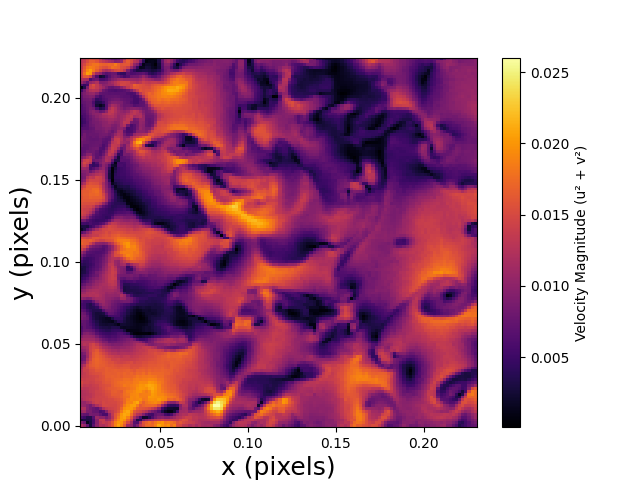

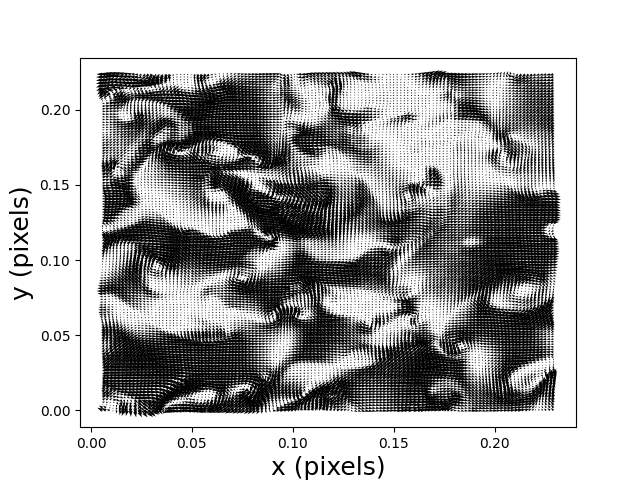

In [6]:

#===========================================================================================
#WORK WITH RESULTS
#===========================================================================================
#Load PIV results
Data = np.load(dirResults+'gpu_field_000.npz')
x = Data['x']#*param['calibration']
y = Data['y']#*param['calibration']
u = Data['u']#*param['calibration']/param['delta_t']
v = Data['v']#*param['calibration']/param['delta_t']



fig, ax1 = plt.subplots()
ax1.quiver(x, y, u, v, scale=1 )
ax1.set_xlabel('x (pixels)',fontsize=18)
ax1.set_ylabel('y (pixels)',fontsize=18)
#plt.show()


velocity_magnitude = np.sqrt(u**2 + v**2)
vmin = velocity_magnitude.min()
  # Set your desired minimum value
vmax = velocity_magnitude.max() # Or set a custom maximum value

fig2, ax = plt.subplots()
c = ax.pcolormesh(x, y, velocity_magnitude, shading='auto', cmap='inferno', vmin=vmin, vmax=vmax)
fig2.colorbar(c, ax=ax, label='Velocity Magnitude (u² + v²)')
ax.set_xlabel('x (pixels)', fontsize=18)
ax.set_ylabel('y (pixels)', fontsize=18)
plt.show()
